 get started by plotting velocity profiles for simulated and fanjin data

In [1]:
from tqdm import tqdm
import os
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib as mpl
import _fj
import plotutils
import command
import twutils
import twanalyse
import stats
import readtrack
import scipy


In [2]:
# paths
notename = "velocity"
pdir = notename+'/'
notedir = os.getcwd()
rsimdir = "exampledata/two_parameters/pilivar_0013.00000_k_spawn_00.50000/"
# rsimdir = "exampledata/two_parameters/pilivar_0013.00000_k_spawn_05.00000/"
simdir = os.path.join(notedir, rsimdir)


In [3]:
# fanjin
debug = None
debug = 100
if debug is not None:
    print('running in debug mode...')
idx, fltrs = _fj.slicehelper.load_linearized_trs('default_crawling_list', debug)


100%|██████████| 100/100 [00:00<00:00, 1886.69it/s]running in debug mode...



In [4]:
# plotting fj data
allvel = np.concatenate([twanalyse._inst_vel(tr) for tr in fltrs])
# allvel = twutils.trim_tail(allvel, 0.05)
# ax = plt.gca()
# outd = plotutils.ax_kdeplot(ax, allvel)
# fjspace, fjpde = outd['space'], outd['pde']
# ax.set_xlabel(r"velocity $\mu m$")
# plt.close()



In [5]:
# The same for simulation data
simdata = os.path.join(simdir, "data/")
trs = readtrack.trackset(ddir=simdata)

for tr in trs:
    tr._clean_bad_dt()
ltrs = [_fj.linearize(tr) for tr in trs]

simvel = np.concatenate([twanalyse._inst_vel(tr) for tr in ltrs])
# ax = plt.gca()
# # simvel = twutils.trim_tail(simvel, 0.05)
# outd = plotutils.ax_kdeplot(ax, simvel)
# simspace, simpde = outd['space'], outd['pde']
# plt.show()


searching for tracks with form /home/dan/usb_twitching/pili/notebook/exampledata/two_parameters/pilivar_0013.00000_k_spawn_00.50000/data/bacterium_*.dat


 Comparing instantaneous velocity of linearized tracks.
 Tracks linearised with respect to a threshold distance 0.12 microns. Instantaneous velocity
 is calculated over 0.1 second interval.

In [6]:
fjvstat = stats.stats(allvel)
simvstat = stats.stats(simvel)
print("Instantaneous velocity")
print(r"Fanjin")
twutils.print_dict(fjvstat)
print(r"Simulated example [{}]".format(rsimdir))
twutils.print_dict(simvstat)



Instantaneous velocity
Fanjin
{
	"mean": 0.013918706870453825,
	"median": 0.008140381093561537,
	"std": 0.03596748602943479,
	"std_error": 3.5102878775917124e-05
}
Simulated example [exampledata/two_parameters/pilivar_0013.00000_k_spawn_00.50000/]
{
	"mean": 0.047287128380971336,
	"median": 0.0,
	"std": 0.21345935323800733,
	"std_error": 0.0005477946688869858
}


In [7]:
import rtw
import txtdata

target = "../../run/two_parameter_model/two_parameters/"
dc = rtw.DataCube(target)
lvel_mean = dc.get_local_array( rtw._make_get("lvel.mean") )
lvel_std = dc.get_local_array( rtw._make_get("lvel.std"))
fjvmean = fjvstat['mean']
fjvstd = fjvstat['std']
rel_lvel_mean = lvel_mean - fjvmean
rel_lvel_std = lvel_std - fjvstd
print("Want to analyse a 2d parameter search dataset with parameters")
table = [ [name] + base  for name, base in zip(dc.pnames, list(dc.basis)) ]
print(tabulate(table, floatfmt='.2f'))


Want to analyse a 2d parameter search dataset with parameters
-------  ----  ----  ----  ----  ----  ----  ----  -----  -----  -----  ------  ----  ----
pilivar  1.00  2.00  2.50  3.00  3.50  4.00  7.00  13.00  20.00  50.00  100.00
k_spawn  0.10  0.50  1.00  1.50  2.00  2.50  3.00   3.50   4.00   4.50    5.00  5.50  6.00
-------  ----  ----  ----  ----  ----  ----  ----  -----  -----  -----  ------  ----  ----


mean velocity relative to FJ data


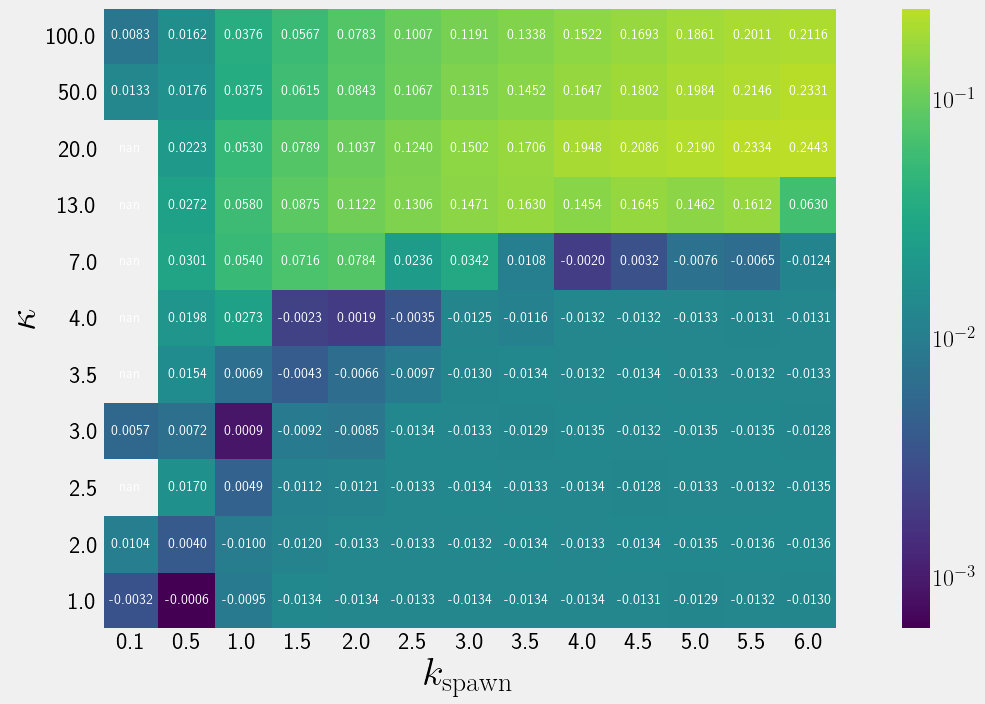

velocity std relative to FJ data


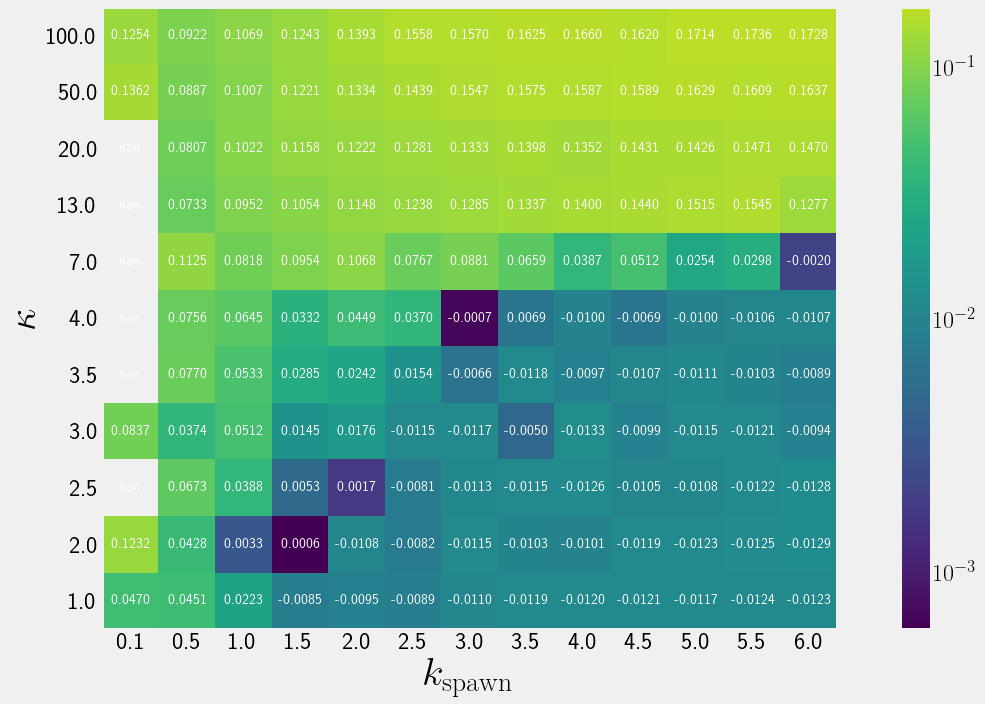

In [8]:
plt.style.use(plotutils.get_style('image'))
def relative_image(expval, localdataname):
    ax = plt.gca()
    meanget = rtw._make_get(localdataname)
    def rmeanget(ld):
        return abs(meanget(ld) - fjvmean)
    def rmeanget_an(ld):
        return meanget(ld) - fjvmean

    rtw._param_image(ax, dc, rmeanget, annotate=True, 
        annotate_form=rtw.anform[localdataname], use_lognorm=True, _getter_an=rmeanget_an)
print("mean velocity relative to FJ data")
relative_image(fjvmean, 'lvel.mean')
plt.show()

print("velocity std relative to FJ data")
relative_image(fjvstd, 'lvel.std')
plt.show()

In [9]:
# so ok there are tracks with similar velocity and standard deviation but we have seen their shapes
# are not so close as we might like.
# we need to quantify this. We can use smoothing kernel to probability distribution and then
# do some kind of weighted least squares but I would like a better approach.
# go to higher order than 2nd momement? Just look at quantiles? KS statistic? 
pass



 We want consider multiple metrics, in this case just mean velocity and standard deviation
 initially. Lets start by finding the pareto set.

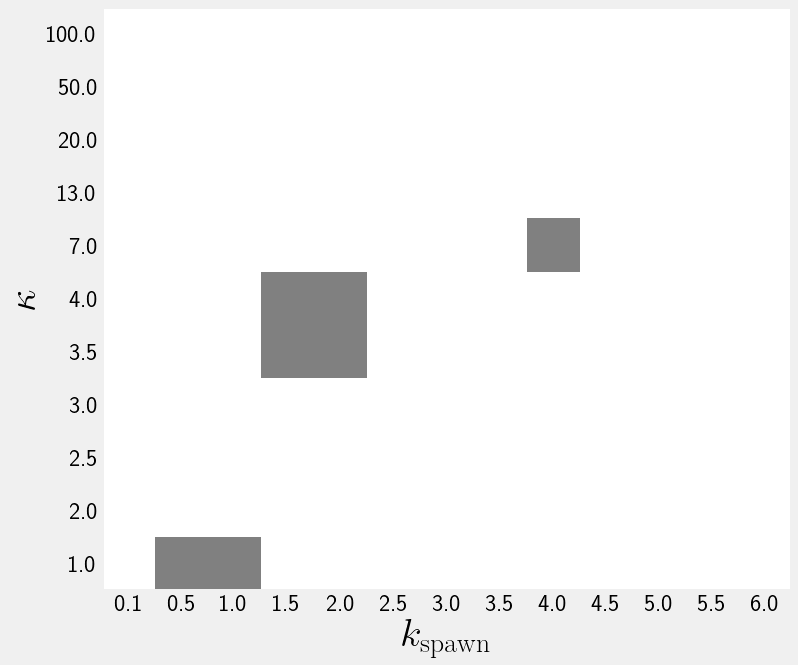

pareto front lims
               min     max               min     max
---------  -------  ------  --------  ------  ------
lvel mean  -0.0095  0.0019  absolute  0.0006  0.0095
lvel abs    0.0003  0.0230  absolute  0.0003  0.0230


In [10]:
# pareto
# https://stackoverflow.com/questions/32791911/fast-calculation-of-pareto-front-in-python

# Fairly fast for many datapoints, less fast for many costs, somewhat readable
def is_pareto_efficient_simple(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
        # Keep any point with a lower cost
            is_efficient[is_efficient] = np.any(costs[is_efficient]<c, axis=1)  
            is_efficient[i] = True  # And keep self
    return is_efficient

# being above or below the experimental data is bad so take absolute value

objective_shape = rel_lvel_mean.shape
mean_objective = np.abs(rel_lvel_mean)
std_objective = np.abs(rel_lvel_std)


objectives = np.column_stack( [ mean_objective.flatten(), std_objective.flatten() ] )
pareto_front = is_pareto_efficient_simple(objectives)
pareto_front = pareto_front.reshape(objective_shape)
pareto_idx = np.nonzero(pareto_front)

# draw pareto front
im_front = np.full(objective_shape, 1.0)
im_front[pareto_idx] = 0.5

ax = plt.gca()

ax.set_xticks(np.arange(len(dc.slice_basis[1])))
ax.set_yticks(np.arange(len(dc.slice_basis[0])))
ax.set_xticklabels(dc.slice_basis[1])
ax.set_yticklabels(dc.slice_basis[0])
ax.set_xlabel(txtdata.prettynames.get(dc.pnames[1]))
ax.set_ylabel(txtdata.prettynames.get(dc.pnames[0]))

norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
Image = ax.imshow(im_front, norm=norm, cmap=plt.cm.gray, origin='lower')
plt.show()

# what is the difference between min and max in pareto front
def minmax(arr):
    return np.min(arr), np.max(arr)
min_mean, max_mean = minmax(rel_lvel_mean[pareto_idx])
min_std, max_std = minmax(rel_lvel_std[pareto_idx])
amin_mean, amax_mean = minmax(mean_objective[pareto_idx])
amin_std, amax_std = minmax(std_objective[pareto_idx])
# 
print('pareto front lims')
headers = ['', 'min', 'max', '', 'min', 'max']
table = tabulate([
    ['lvel mean ', min_mean, max_mean, 'absolute', amin_mean, amax_mean],
    ['lvel abs ', min_std, max_std, 'absolute', amin_std, amax_std]
    ], headers, floatfmt='.4f')
print(table)

 We may want to just transform how multobjective optimisation problem into a more straightforward
 problem by using a linear combination of objective functions.
 Both parameters have similar ranges in the pareto front so
 in this case so lets give them equal weight.

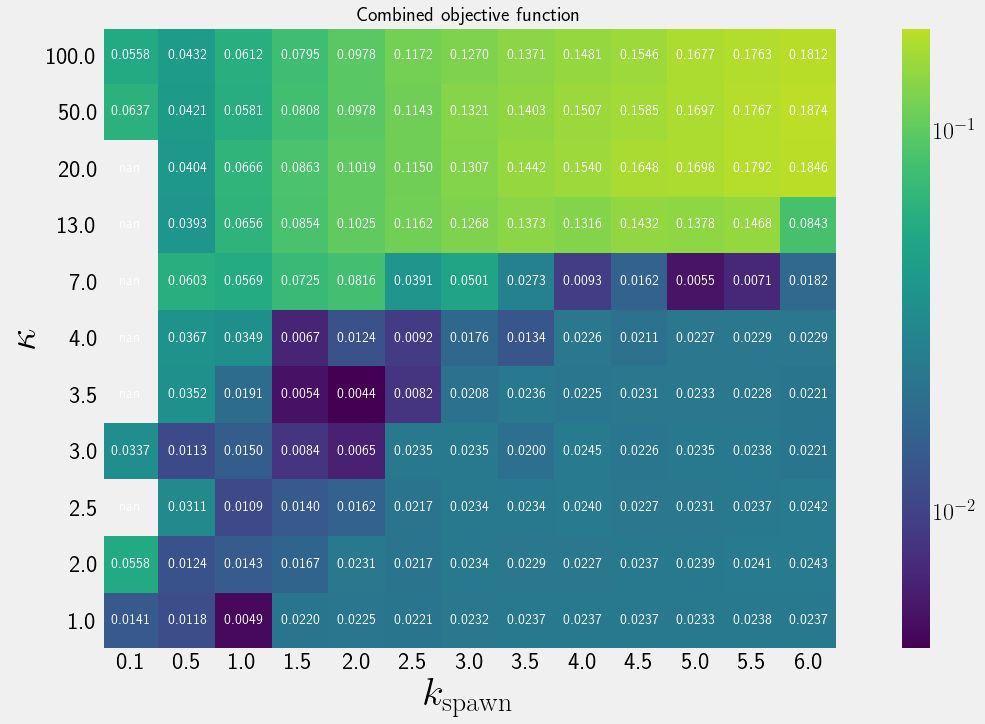

Hand picking some of the parameters from across the parameter space.
  pilivar    k_spawn
---------  ---------
     1.00       1.00
     3.50       2.00
     7.00       5.00


In [11]:

# combine into a single objective function
lcobjective = (mean_objective + std_objective)/2
ax = plt.gca()
rtw._data_image(ax, dc, lcobjective, annotate=True, annotate_form=rtw.anform['lvel.mean'])
ax.set_title("Combined objective function")
plt.show()

# reading off good values for both parameters
eye_values = [[1.0, 1.0], [3.5, 2.0], [7.0, 5.0]]
eye_table = tabulate(eye_values, dc.pnames, floatfmt='.2f')
print('Hand picking some of the parameters from across the parameter space.')
print(eye_table)

In [12]:

# retrieve simulation index and path
eye_idx = [dc.find_index(xy) for xy in eye_values]
eye_dir = [dc.dircube[tuple(idx)] for idx in eye_idx]


# load linearized velocities
# for i, eye
lsimvel = []
for i, idx in enumerate(eye_idx):
    simdir = eye_dir[i]
    print('loading data from ', simdir)
    simdata = os.path.join(simdir, "data/")
    trs = readtrack.trackset(ddir=simdata)
    for tr in trs:
        tr._clean_bad_dt()
    ltrs = [_fj.linearize(tr) for tr in trs]
    track_vel = [twanalyse._inst_vel(tr) for tr in ltrs]
    simvel = np.concatenate(track_vel)
    # simvel = twutils.trim_tail(simvel, 0.05)
    lsimvel.append(simvel)


loading data from  ../../run/two_parameter_model/two_parameters/pilivar_0001.00000_k_spawn_01.00000/
searching for tracks with form ../../run/two_parameter_model/two_parameters/pilivar_0001.00000_k_spawn_01.00000/data/bacterium_*.dat
loading data from  ../../run/two_parameter_model/two_parameters/pilivar_0003.50000_k_spawn_02.00000/
searching for tracks with form ../../run/two_parameter_model/two_parameters/pilivar_0003.50000_k_spawn_02.00000/data/bacterium_*.dat
loading data from  ../../run/two_parameter_model/two_parameters/pilivar_0007.00000_k_spawn_05.00000/
searching for tracks with form ../../run/two_parameter_model/two_parameters/pilivar_0007.00000_k_spawn_05.00000/data/bacterium_*.dat


In [13]:
# check the bounds
table = []
for i, idx in enumerate(eye_idx):
    simvel = lsimvel[i]
    row = [os.path.basename(os.path.normpath(eye_dir[i]))]
    row.extend(np.quantile(simvel, [0.0, 0.25, 0.5, 0.75, 1.0]).tolist())
    table.append(row)
table.append(['Fanjin', *np.quantile(allvel, [0.0, 0.25, 0.5, 0.75, 1.0]).tolist()])
print(tabulate(table, headers=['simulation path', 'min', '1st', '2nd', '3rd', 'max'], floatfmt='.4f'))


simulation path                         min     1st     2nd     3rd      max
-----------------------------------  ------  ------  ------  ------  -------
pilivar_0001.00000_k_spawn_01.00000  0.0000  0.0000  0.0000  0.0000   3.7041
pilivar_0003.50000_k_spawn_02.00000  0.0000  0.0000  0.0000  0.0000   3.8298
pilivar_0007.00000_k_spawn_05.00000  0.0000  0.0000  0.0000  0.0000   4.0678
Fanjin                               0.0000  0.0038  0.0081  0.0160  10.1829


In [14]:
# We notice immediately from printing the 1st, 2nd and 3rd quantiles that these distributions
# are not all that similar. Simulated tracks in this dataset spend a large portion of the time
# idling at close to 0 velocity. This is even after linearising the trajectory. (Worth checking again)



Computing pdf with 195215 data points at resolution 200
Computing pdf with 199542 data points at resolution 200
Computing pdf with 199961 data points at resolution 200
Computing pdf with 1049869 data points at resolution 200


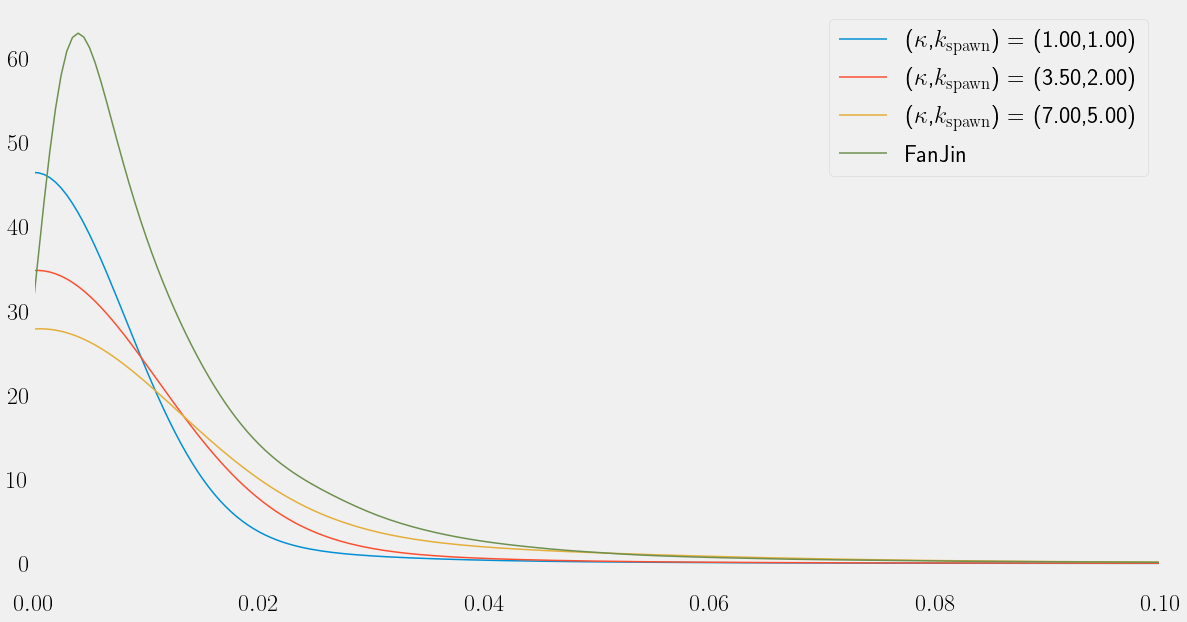

In [15]:

ax = plt.gca()
plt.style.use(plotutils.get_style('jupyter'))
handle = []
label = []
xlims = (0, 0.1)
use_hist = False
for i, simvel in enumerate(lsimvel):
    outd = plotutils.ax_kdeplot(ax, simvel, xlims=xlims, hist=use_hist)
    handle.append(outd['handle'])
    label.append("({},{}) = ({:4.2f},{:4.2f})".format(*dc.prettynames(), *eye_values[i]))
outd = plotutils.ax_kdeplot(ax, allvel, xlims=xlims, hist=use_hist)
label.append('FanJin')
handle.append(outd['handle'])
ax.legend(handle, label)
ax.set_xlim(xlims)
plt.show()


 These are probability distributions and should all have the same area. Most likely
 the kernal we use to compute probability density is not reflected at x = 0 but this library
 doesn't give the option to change that.
 It's always important to plot a straightforward histogram.

Computing pdf with 195215 data points at resolution 200
Computing pdf with 199542 data points at resolution 200
Computing pdf with 199961 data points at resolution 200
Computing pdf with 1049869 data points at resolution 200


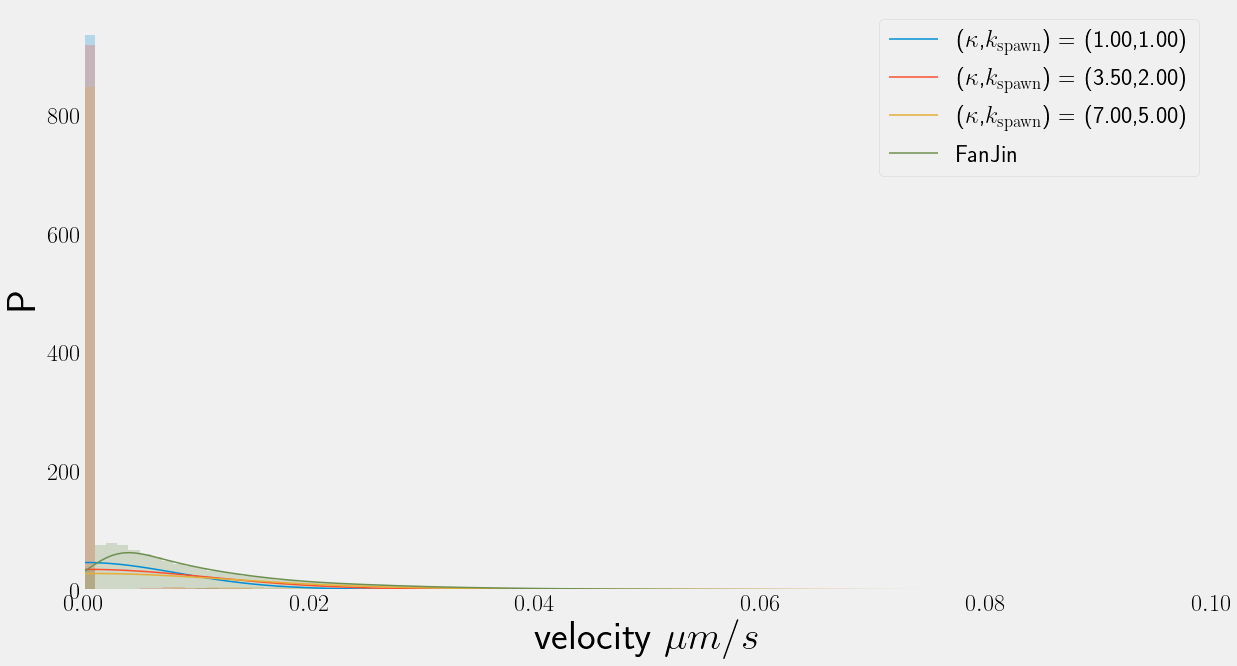

In [16]:

ax = plt.gca()
plt.style.use(plotutils.get_style('jupyter'))
handle = []
label = []
xlims = (0, 0.1)
use_hist = True
for i, simvel in enumerate(lsimvel):
    outd = plotutils.ax_kdeplot(ax, simvel, xlims=xlims, hist=use_hist)
    handle.append(outd['handle'])
    label.append("({},{}) = ({:4.2f},{:4.2f})".format(*dc.prettynames(), *eye_values[i]))
outd = plotutils.ax_kdeplot(ax, allvel, xlims=xlims, hist=use_hist)
label.append('FanJin')
handle.append(outd['handle'])
ax.legend(handle, label)
ax.set_xlim(xlims)
ax.set_ylabel('P')
ax.set_xlabel(r'velocity $\mu m/s$')
plt.show()


 A histogram shows the problem with simulated tracks spending large amounts of time
 stationary. It's been a while so I do need to test the code again for bugs and
 before I analyse the trajectories to understand why this happens.
 it's also worth noting that standard deviation of velocity velocity is not very useful here
 because the simulated distribution is so skewed.

cut out velocity <  0.05
which leaves 0.05% of the data
velocity (min, max) =  0.050006076054444015 4.067760388574589
Computing pdf with 10101 data points at resolution 100


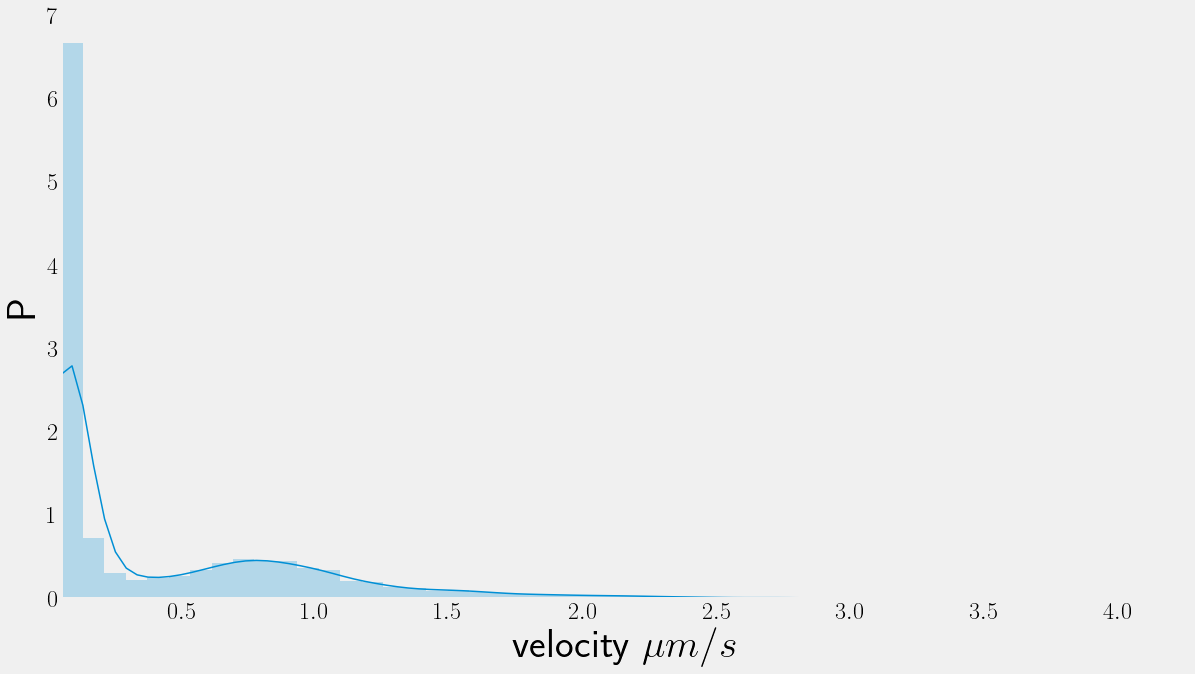

In [17]:
# as Jure suggests, throw away the low velocity data so that we can see the high velocity distribution
low_threshold = 0.05
sim_high_vel = simvel[simvel > low_threshold]
print('cut out velocity < ', low_threshold)
print('which leaves {:4.2f}% of the data'.format(sim_high_vel.size/simvel.size))
ax = plt.gca()
print('velocity (min, max) = ', np.min(sim_high_vel), np.max(sim_high_vel))
plotutils.ax_kdeplot(ax, sim_high_vel, res=100, hist=True)
ax.set_xlim(xmin=sim_high_vel.min())
ax.set_ylabel('P')
ax.set_xlabel(r'velocity $\mu m/s$')
plt.show()


